# Pipeline de Entrenamiento IQL Self-Play

Este notebook entrena agentes de Aprendizaje Q Independiente (IQL) en self-play para una variedad de juegos simultáneos.
Para cada juego:
1. Inicializa el entorno del juego y múltiples agentes IQL.
2. Entrena los agentes para que jueguen entre sí durante un número específico de episodios e iteraciones.
3. Guarda la Q-table aprendida para cada agente.
4. Guarda los datos de entrenamiento (por ejemplo, recompensas promedio por iteración) para análisis posterior.

El entrenamiento self-play permite que los agentes desarrollen estrategias sofisticadas al aprender contra oponentes de capacidades similares, lo que conduce a un juego más robusto y competitivo.

Los modelos y datos guardados se almacenarán en el directorio `iql_trainings`, organizados por juego.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time 

from games.rps import RPS
from games.mp import MP
from games.blotto import Blotto
from games.foraging import Foraging

from agents.iql_agent import IQLAgent, IQLAgentConfig

from base.game import SimultaneousGame, AgentID, ActionDict
from base.agent import Agent

## 1. Definir Juegos y Configuraciones

Especificar los juegos a probar y sus respectivas configuraciones.
La función auxiliar `get_game_instance` se utilizará para crear objetos de juego.

In [ ]:
games_to_test = [
    {"name": "RPS", "game_class": RPS, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "MP", "game_class": MP, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "Blotto_S10_N5", "game_class": Blotto, "config": {"S": 10, "N": 5}, "train_episodes": 2000, "train_iterations": 1000},
    {"name": "Foraging_5x5_2p_3f", "game_class": Foraging, "config": {"config": "Foraging-5x5-2p-3f-v3", "seed": 123}, "train_episodes": 2000, "train_iterations": 600}
]

def get_game_instance(game_entry: dict) -> SimultaneousGame:
    """Crea una instancia de juego a partir de una entrada de juego."""
    game_class = game_entry["game_class"]
    config = game_entry["config"]
    if game_entry["name"].startswith("Blotto") or game_entry["name"].startswith("Foraging"):
        return game_class(**config)
    else:
        return game_class()

TRAINING_DATA_DIR = "iql_trainings"
if not os.path.exists(TRAINING_DATA_DIR):
    os.makedirs(TRAINING_DATA_DIR)
    print(f"Directorio creado: {TRAINING_DATA_DIR}")
else:
    print(f"El directorio ya existe: {TRAINING_DATA_DIR}")

El directorio ya existe: iql_trainings


## 2. Funciones Auxiliares para Entrenamiento IQL Self-Play

Estas funciones manejan la creación de agentes IQL, ejecución de episodios y entrenamiento específicamente para escenarios self-play donde los agentes IQL aprenden jugando entre sí.

In [ ]:
def create_agents(game: SimultaneousGame, base_config: IQLAgentConfig = None) -> dict[AgentID, IQLAgent]:
    """Crea agentes IQL para todos los agentes en el juego para entrenamiento self-play."""
    if base_config is None:
        base_config = IQLAgentConfig(alpha=0.1, gamma=0.99, epsilon=0.9, min_epsilon=0.05, epsilon_decay=0.98, seed=123, optimistic_init=0.5)
    
    agents = {}
    for agent_id in game.agents:
        agent_config = IQLAgentConfig(
            alpha=base_config.alpha,
            gamma=base_config.gamma,
            epsilon=base_config.epsilon,
            min_epsilon=base_config.min_epsilon,
            epsilon_decay=base_config.epsilon_decay,
            max_t=getattr(base_config, 'max_t', 1000),
            seed=base_config.seed + game.agent_name_mapping[agent_id] if base_config.seed is not None else None,
            optimistic_init=getattr(base_config, 'optimistic_init', 0.1),
            use_reward_shaping=getattr(base_config, 'use_reward_shaping', True)
        )
        agents[agent_id] = IQLAgent(game=game, agent=agent_id, config=agent_config)
    return agents

def play_episode(game: SimultaneousGame, agents: dict[AgentID, Agent], max_steps_per_episode=100, learn_agent_id: AgentID = None, verbose=False, render=False):
    """Juega un solo episodio con los agentes dados. Todos los agentes IQL aprenden por defecto."""
    game.reset()
    for agent_id, agent in agents.items():
        agent.reset()
        if isinstance(agent, IQLAgent):
            agent.learn = (agent_id == learn_agent_id) if learn_agent_id is not None else True

    cumulative_rewards = {agent_id: 0.0 for agent_id in game.agents}
    is_foraging = isinstance(game, Foraging)
    
    for step in range(max_steps_per_episode):
        if is_foraging and game.env.unwrapped._game_over:
            break
        if not is_foraging and all(game.terminations.values()):
             break

        actions = {agent_id: agents[agent_id].action() for agent_id in game.agents}
        game.step(actions)

        for agent_id in game.agents:
            reward = game.reward(agent_id)
            if isinstance(reward, list):
                reward = float(sum(reward))
            
            if isinstance(agents[agent_id], IQLAgent) and agents[agent_id].learn: 
                agents[agent_id].last_reward = reward
                agents[agent_id].update()
            
            cumulative_rewards[agent_id] += reward

        if verbose and step % 10 == 0:
            print(f"  Paso {step}: Acciones: {actions}, Recompensas: { {a: game.reward(a) for a in game.agents} }")
        
        if render:
            game.render()
            time.sleep(0.1)
            
        if all(game.terminations.values()) or (is_foraging and game.env.unwrapped._game_over):
            break
            
    for agent_id, agent in agents.items():
        if isinstance(agent, IQLAgent) and agent.learn and (learn_agent_id is None or agent_id == learn_agent_id):
            agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)
    
    return cumulative_rewards

def train_agents_for_game(game: SimultaneousGame, agents: dict[AgentID, IQLAgent], episodes: int, iterations: int, max_steps_per_episode=100):
    """Entrena agentes IQL en self-play para un juego dado a lo largo de múltiples iteraciones y episodios."""
    print(f"Iniciando entrenamiento IQL self-play para {game.__class__.__name__}...")
    
    all_iterations_average_rewards = {agent_id: [] for agent_id in game.agents}

    for i in range(1, iterations + 1):
        iteration_total_rewards = {agent_id: 0.0 for agent_id in game.agents}
        for ep in range(episodes):
            for agent in agents.values():
                agent.learn = True
            
            episode_rewards = play_episode(game, agents, max_steps_per_episode=max_steps_per_episode, learn_agent_id=None)
            for agent_id in game.agents:
                iteration_total_rewards[agent_id] += episode_rewards[agent_id]
        
        for agent_id in game.agents:
            avg_reward_iteration = iteration_total_rewards[agent_id] / episodes
            all_iterations_average_rewards[agent_id].append(avg_reward_iteration)

        if i % (iterations // 10 or 1) == 0: 
            print(f"  Iteración {i}/{iterations} completada.")
            for agent_id in game.agents:
                print(f"    Agente {agent_id}: Recompensa Promedio = {all_iterations_average_rewards[agent_id][-1]:.2f}, Epsilon = {agents[agent_id].epsilon:.3f}")
                
    print(f"Entrenamiento IQL self-play completado para {game.__class__.__name__}.")
    return all_iterations_average_rewards

def save_agent_q_table(agent: IQLAgent, game_name: str, agent_id_str: str, base_path: str):
    """Guarda la Q-table de un agente en un archivo."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
    
    file_path = os.path.join(game_specific_path, f"agent_{agent_id_str}_q_table.pkl")
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(agent.Q, f)
        print(f"  Q-table guardada para el agente {agent_id_str} en {file_path}")
    except Exception as e:
        print(f"  Error al guardar la Q-table para el agente {agent_id_str}: {e}")

def save_training_data(data: dict, game_name: str, base_path: str, filename="training_rewards.pkl"):
    """Guarda datos de entrenamiento (por ejemplo, recompensas) en un archivo."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
        
    file_path = os.path.join(game_specific_path, filename)
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"  Datos de entrenamiento guardados para {game_name} en {file_path}")
    except Exception as e:
        print(f"  Error al guardar los datos de entrenamiento para {game_name}: {e}")


## 3. Bucle de Entrenamiento IQL Self-Play

Iterar a través de cada juego, entrenar agentes IQL para que jueguen entre sí en self-play, y guardar sus Q-tables y datos de entrenamiento. Esto crea agentes competitivos que aprenden a jugar de manera óptima contra oponentes de un nivel de habilidad similar.

In [ ]:
GAME_MAX_STEPS = {
    "RPS": 1,
    "MP": 1,
    "Blotto_S3_N2": 1,
    "Blotto_S10_N5": 1,
    "Foraging_5x5_2p_3f": 200
}

def calculate_epsilon_decay(total_episodes, start_epsilon, min_epsilon, decay_fraction=0.7):
    """Calcula la tasa de decaimiento epsilon para que epsilon alcance min_epsilon después de decay_fraction del total de episodios."""
    target_episodes = int(total_episodes * decay_fraction)
    if target_episodes <= 0:
        return 0.999
    decay_rate = (min_epsilon / start_epsilon) ** (1.0 / target_episodes)
    return max(0.9, min(0.9999, decay_rate))
for game_entry in games_to_test:
    game_name = game_entry["name"]
    print(f"--- Entrenando IQL Self-Play para el juego: {game_name} ---")

    train_episodes = game_entry["train_episodes"]
    train_iterations = game_entry["train_iterations"]
    total_training_episodes = train_episodes * train_iterations

    game_instance = get_game_instance(game_entry)
    
    if not game_instance.agents:
        print(f"No se encontraron agentes para el juego {game_name}. Omitiendo.")
        continue

    if game_name.startswith("Foraging"):
        start_epsilon = 1.0
        min_epsilon = 0.1
        epsilon_decay = calculate_epsilon_decay(total_training_episodes, start_epsilon, min_epsilon)
        
        iql_config = IQLAgentConfig(
            alpha=0.1,           
            gamma=0.95,          
            epsilon=start_epsilon,
            min_epsilon=min_epsilon,
            epsilon_decay=epsilon_decay,
            seed=123,
            optimistic_init=0.1,
            use_reward_shaping=False
        )
    else:
        start_epsilon = 0.9
        min_epsilon = 0.05
        epsilon_decay = calculate_epsilon_decay(total_training_episodes, start_epsilon, min_epsilon)
        
        iql_config = IQLAgentConfig(
            alpha=0.1,
            gamma=0.99,
            epsilon=start_epsilon,
            min_epsilon=min_epsilon,
            epsilon_decay=epsilon_decay,
            seed=123,
            optimistic_init=0.1
        )

    agents = create_agents(game_instance, iql_config)
    
    max_steps = GAME_MAX_STEPS.get(game_name, 100)
    
    print(f"Entrenando {train_iterations} iteraciones de {train_episodes} episodios cada una...")
    print(f"Total de episodios: {total_training_episodes}, Decaimiento epsilon: {epsilon_decay:.6f}")
    print(f"Configuración IQL: alpha={iql_config.alpha}, gamma={iql_config.gamma}, epsilon={iql_config.epsilon}->{iql_config.min_epsilon}")
    
    training_rewards_history = train_agents_for_game(
        game_instance, agents, train_episodes, train_iterations, max_steps
    )

    game_specific_save_name = f"{game_name}"
    save_training_data(training_rewards_history, game_specific_save_name, TRAINING_DATA_DIR)
    
    for agent_id, agent_object in agents.items():
        if isinstance(agent_object, IQLAgent):
            agent_id_simple = str(game_instance.agent_name_mapping[agent_id])
            save_agent_q_table(agent_object, game_specific_save_name, agent_id_simple, TRAINING_DATA_DIR)
            num_states = len(agent_object.Q)
            avg_q_values = np.mean([np.mean(q_vals) for q_vals in agent_object.Q.values()]) if num_states > 0 else 0
            print(f"  Agente {agent_id_simple}: {num_states} estados aprendidos, valor Q promedio: {avg_q_values:.3f}")
        else:
            print(f"Advertencia: El agente {agent_id} no es un IQLAgent. Q-table no guardada.")
            
    print(f"--- Finalizó el entrenamiento y guardado para {game_specific_save_name} (IQL Self-Play) ---")

print("Todos los procesos de entrenamiento IQL Self-Play completados.")

--- Entrenando IQL Self-Play para el juego: RPS ---
Entrenando 500 iteraciones de 1000 episodios cada una...
Total de episodios: 500000, Decaimiento epsilon: 0.999900
Configuración IQL: alpha=0.1, gamma=0.99, epsilon=0.9->0.05
Iniciando entrenamiento IQL self-play para RPS...
  Iteración 50/500 completada.
    Agente agent_0: Recompensa Promedio = 0.01, Epsilon = 0.050
    Agente agent_1: Recompensa Promedio = -0.01, Epsilon = 0.050
  Iteración 100/500 completada.
    Agente agent_0: Recompensa Promedio = 0.02, Epsilon = 0.050
    Agente agent_1: Recompensa Promedio = -0.02, Epsilon = 0.050
  Iteración 150/500 completada.
    Agente agent_0: Recompensa Promedio = -0.01, Epsilon = 0.050
    Agente agent_1: Recompensa Promedio = 0.01, Epsilon = 0.050
  Iteración 200/500 completada.
    Agente agent_0: Recompensa Promedio = 0.01, Epsilon = 0.050
    Agente agent_1: Recompensa Promedio = -0.01, Epsilon = 0.050
  Iteración 250/500 completada.
    Agente agent_0: Recompensa Promedio = -0.01,

## 4. Graficación de Resultados de Entrenamiento (Ejemplo)

Esta sección muestra cómo cargar y graficar los datos de entrenamiento guardados (recompensas promedio por iteración).

\n--- Graficando Resultados de Entrenamiento IQL Self-Play ---


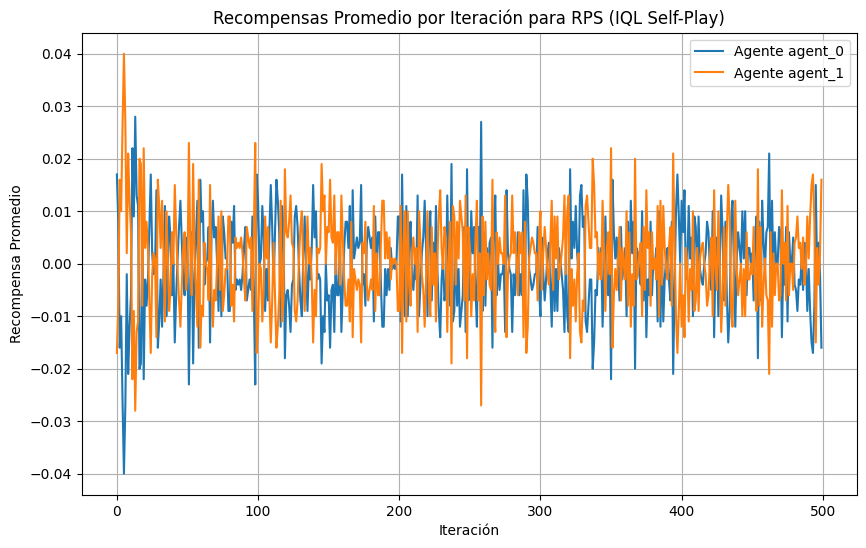

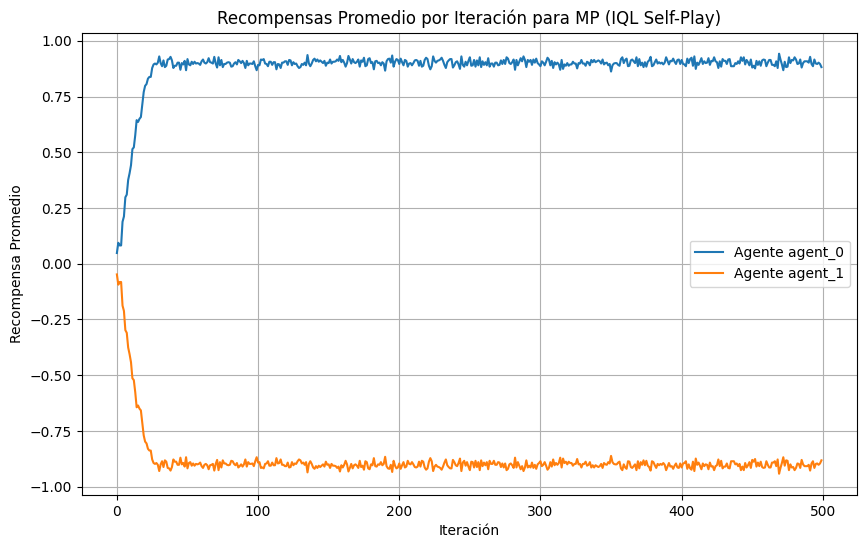

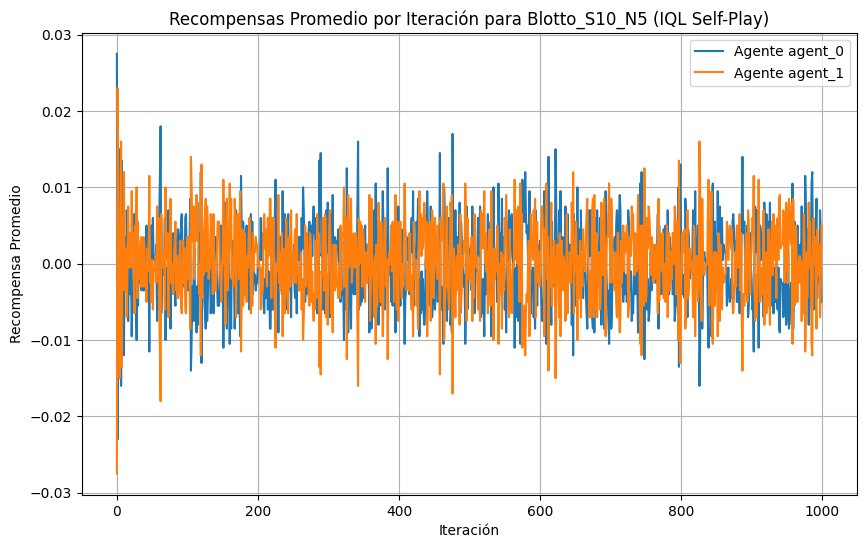

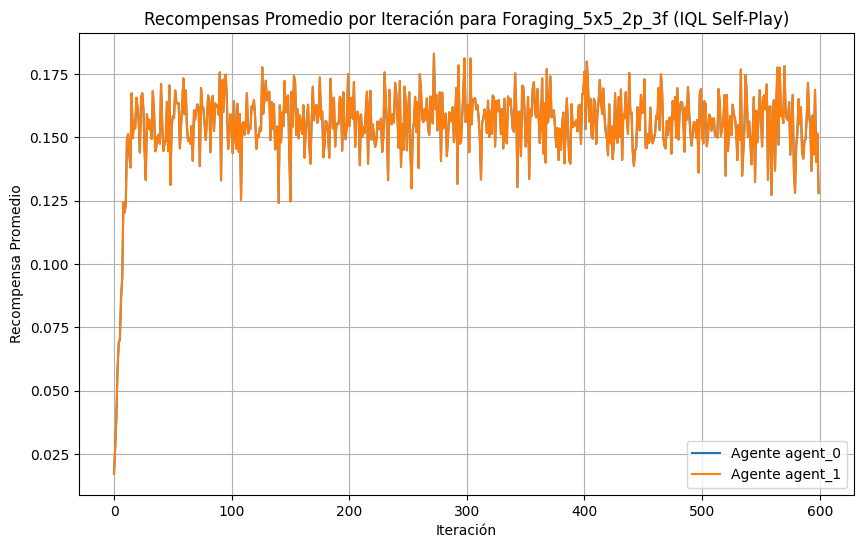

In [ ]:
def plot_training_results(game_name, base_path, data_subdir_name=None):
    """Grafica resultados de entrenamiento. data_subdir_name es el subdirectorio específico bajo base_path/game_name."""
    if data_subdir_name: 
        data_path = os.path.join(base_path, data_subdir_name, "training_rewards.pkl")
    else: 
        data_path = os.path.join(base_path, game_name, "training_rewards.pkl")

    if not os.path.exists(data_path):
        print(f"No se encontraron datos de entrenamiento para {game_name} en {data_path}")
        return

    with open(data_path, 'rb') as f:
        training_rewards = pickle.load(f)

    plt.figure(figsize=(10, 6))
    for agent_id, rewards_list in training_rewards.items():
        plt.plot(rewards_list, label=f"Agente {agent_id}")
    
    plot_title = f"Recompensas Promedio por Iteración para {game_name}"
    if data_subdir_name and game_name in data_subdir_name: 
         plot_title = f"Recompensas Promedio por Iteración para {data_subdir_name} (IQL Self-Play)"
    elif data_subdir_name: 
        plot_title = f"Recompensas Promedio por Iteración para {game_name} ({data_subdir_name})"
        
    plt.title(plot_title)
    plt.xlabel("Iteración")
    plt.ylabel("Recompensa Promedio")
    plt.legend()
    plt.grid(True)
    plt.show()

if games_to_test:
    print("\\n--- Graficando Resultados de Entrenamiento IQL Self-Play ---")
    for game_entry in games_to_test:
        game_name = game_entry["name"]
        plot_training_results(game_name, TRAINING_DATA_DIR, data_subdir_name=game_name)


## 5. Carga de Agentes Entrenados (Ejemplo para uso futuro)

Esta sección muestra una forma conceptual de cargar las Q-tables de vuelta en los agentes.
Esto típicamente se haría en un notebook separado para pruebas o implementación.

In [ ]:
def load_agent_q_table(agent: IQLAgent, game_name: str, agent_id_str: str, base_path: str, data_subdir_name: str = None):
    """Carga una Q-table en un agente desde un archivo."""
    if data_subdir_name: 
        file_path = os.path.join(base_path, data_subdir_name, f"agent_{agent_id_str}_q_table.pkl")
    else:
        file_path = os.path.join(base_path, game_name, f"agent_{agent_id_str}_q_table.pkl")

    if not os.path.exists(file_path):
        print(f"  No se encontró Q-table para el agente {agent_id_str} en {file_path}")
        return False
    
    try:
        with open(file_path, 'rb') as f:
            q_table = pickle.load(f)
        agent.Q = q_table
        agent.learn = False 
        agent.epsilon = 0 
        print(f"  Q-table cargada para el agente {agent_id_str} desde {file_path}")
        print(f"    La Q-table tiene {len(q_table)} estados")
        if len(q_table) > 0:
            avg_q = np.mean([np.mean(q_vals) for q_vals in q_table.values()])
            print(f"    Valor Q promedio: {avg_q:.3f}")
        return True
    except Exception as e:
        print(f"  Error al cargar la Q-table para el agente {agent_id_str}: {e}")
        return False

def test_trained_agents(game_name: str, num_test_episodes: int = 10):
    """Prueba agentes IQL entrenados ejecutando episodios de evaluación."""
    print(f"\n=== Probando Agentes Entrenados para {game_name} ===")
    
    game_entry = None
    for entry in games_to_test:
        if entry["name"] == game_name:
            game_entry = entry
            break
    
    if game_entry is None:
        print(f"Juego {game_name} no encontrado en games_to_test")
        return
    
    game_instance = get_game_instance(game_entry)
    
    eval_config = IQLAgentConfig(epsilon=0.0, seed=123)
    agents = create_agents(game_instance, eval_config)
    
    all_loaded = True
    for agent_id, agent in agents.items():
        if isinstance(agent, IQLAgent):
            agent_id_str = str(game_instance.agent_name_mapping[agent_id])
            if not load_agent_q_table(agent, game_name, agent_id_str, TRAINING_DATA_DIR, game_name):
                all_loaded = False
                break
    
    if not all_loaded:
        print(f"No se pudieron cargar todas las Q-tables para {game_name}. Asegúrate de que el entrenamiento se completó con éxito.")
        return
    
    print(f"\nEjecutando {num_test_episodes} episodios de prueba...")
    max_steps = GAME_MAX_STEPS.get(game_name, 100)
    total_rewards = {agent_id: 0.0 for agent_id in game_instance.agents}
    
    for episode in range(num_test_episodes):
        episode_rewards = play_episode(
            game_instance, agents, 
            max_steps_per_episode=max_steps,
            learn_agent_id=None,  
            verbose=(episode == 0), 
            render=False
        )
        
        for agent_id in game_instance.agents:
            total_rewards[agent_id] += episode_rewards[agent_id]
    
    print(f"\n=== Resultados de la Prueba para {game_name} ===")
    for agent_id in game_instance.agents:
        avg_reward = total_rewards[agent_id] / num_test_episodes
        agent_idx = game_instance.agent_name_mapping[agent_id]
        print(f"  Agente {agent_idx}: Recompensa promedio = {avg_reward:.3f}")
    
    return total_rewards

if games_to_test:
    print("\n--- Ejemplo: Cargando agentes IQL entrenados (Self-Play) para Foraging_5x5_2p_3f ---")
    game_to_load = "Foraging_5x5_2p_3f" # Juego de ejemplo
    
    game_entry_to_load = None
    for g_entry in games_to_test:
        if g_entry["name"] == game_to_load:
            game_entry_to_load = g_entry
            break
    
    if game_entry_to_load is None:
        print(f"No se pudo encontrar entrada de juego para {game_to_load}. Omitiendo ejemplo de carga.")
    else:
        game_instance_load = get_game_instance(game_entry_to_load)
        
        if game_instance_load.agents:
            iql_eval_config = IQLAgentConfig(epsilon=0, seed=123) 
            agents_loaded = create_agents(game_instance_load, base_config=iql_eval_config)

            all_loaded_successfully = True
            for agent_id, agent_to_load in agents_loaded.items():
                if isinstance(agent_to_load, IQLAgent):
                    agent_id_simple_load = str(game_instance_load.agent_name_mapping[agent_id])
                    if not load_agent_q_table(agent_to_load, game_to_load, agent_id_simple_load, TRAINING_DATA_DIR, data_subdir_name=game_to_load):
                        all_loaded_successfully = False
                        print(f"No se pudo cargar la Q-table para el agente IQL {agent_id} para {game_to_load} (Self-Play).")
                        break 
                else:
                    print(f"Error: El agente {agent_id} no es un IQLAgent en el conjunto cargado.")
                    all_loaded_successfully = False
                    break
            
            if all_loaded_successfully:
                print(f"Se cargaron con éxito todos los agentes IQL para {game_to_load} (Self-Play).")
                print(f"\n--- Jugando un episodio con agentes IQL cargados para {game_to_load} ---")
                rewards = play_episode(game_instance_load, agents_loaded, 
                                     max_steps_per_episode=GAME_MAX_STEPS.get(game_to_load,100),
                                     learn_agent_id=None, 
                                     verbose=True, render=False)
                print(f"Recompensas del episodio: {rewards}")
            else:
                print(f"No se pudieron cargar todos los agentes para {game_to_load}. Abortando episodio de prueba.")
        else:
            print(f"No se pudo ejecutar el ejemplo de carga para {game_to_load} ya que no se encontraron agentes.")


--- Ejemplo: Cargando agentes IQL entrenados (Self-Play) para Foraging_5x5_2p_3f ---
  Q-table cargada para el agente 0 desde iql_trainings/Foraging_5x5_2p_3f/agent_0_q_table.pkl
    La Q-table tiene 20 estados
    Valor Q promedio: 0.066
  Q-table cargada para el agente 1 desde iql_trainings/Foraging_5x5_2p_3f/agent_1_q_table.pkl
    La Q-table tiene 20 estados
    Valor Q promedio: 0.073
Se cargaron con éxito todos los agentes IQL para Foraging_5x5_2p_3f (Self-Play).

--- Jugando un episodio con agentes IQL cargados para Foraging_5x5_2p_3f ---
  Paso 0: Acciones: {'agent_0': 1, 'agent_1': 1}, Recompensas: {'agent_0': 0, 'agent_1': 0}
  Paso 10: Acciones: {'agent_0': 2, 'agent_1': 2}, Recompensas: {'agent_0': 0, 'agent_1': 0}
  Paso 20: Acciones: {'agent_0': 2, 'agent_1': 0}, Recompensas: {'agent_0': 0, 'agent_1': 0}
  Paso 30: Acciones: {'agent_0': 2, 'agent_1': 4}, Recompensas: {'agent_0': 0, 'agent_1': 0}
  Paso 40: Acciones: {'agent_0': 2, 'agent_1': 5}, Recompensas: {'agent_0': 